In [115]:
import warnings

import pandas as pd
from numpy import (
    mean, std
)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    cross_val_score
)

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import VotingClassifier

# **Info**
---
**@By:** Kaiziferr

**@Git:** https://github.com/Kaiziferr

# **Utils**
---

In [116]:
def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)

def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else generate_colors()[0]
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        height_text = height
        if kwards['p'] == True:
          percentage = round(height/data.shape[0], 5)
          height_text = f'{height} ({percentage})'
        ax.text(p.get_x()+p.get_width()/2., height + 1, height_text, ha="center")
      except:
        pass

  except Exception as e:
    print(e)


# **Config**
---

In [117]:
random_seed = 12354
warnings.filterwarnings('ignore')
sns.set(style='darkgrid')
title_data = ''
palete = sns.color_palette('deep').as_hex()

#**Data**
---

In [118]:
url = 'https://raw.githubusercontent.com/Kaiziferr/datasets/main/cryptojacking.csv'
data = pd.read_csv(url, dtype=str).drop('Unnamed: 0', axis=1)

In [119]:
data.head(3)

,Name,Netflows,First_Protocol,Second_Protocol,Third_Protocol,p1_d,p2_d,p3_d,duration,max_d,...,first_dp,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type
0,0-csves/0.csv,65,TCP,UDP,NaN,18.939,168.173,194.287,7845.125999999999,244.362,...,443,80.0,123.0,3.0,7.0,22.0,127.0,255.0,1888.0,0
1,0-csves/1.csv,18,UDP,TCP,NaN,0.0,0.0,0.0,0.086,0.044,...,443,53.0,53195.0,1.0,1.0,1.0,37.0,47.0,64.0,0
2,1-csves/0.csv,10,UDP,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,53,39308.0,54454.0,1.0,1.0,1.0,34.0,43.0,61.75,0


The data types of the columns are updated

In [120]:
data[[
    'p1_d', 'p2_d', 'p3_d',
    'duration', 'max_d', 'min_d',
    'Avg_bps', 'Avg_pps','Avg_bpp',
    'p1_ip', 'p2_ip', 'p3_ip',
    'p1_ib', 'p2_ib','p3_ib']] = data[[
    'p1_d', 'p2_d', 'p3_d',
    'duration', 'max_d', 'min_d',
    'Avg_bps', 'Avg_pps','Avg_bpp',
    'p1_ip', 'p2_ip', 'p3_ip',
    'p1_ib', 'p2_ib','p3_ib']].astype('float64')


data[[
    'Netflows', '#packets',
    '#Bytes', '#sp', '#dp']] = data[[
    'Netflows', '#packets',
    '#Bytes', '#sp', '#dp']].astype('int64')

It is evident that there is an imbalance in the traffic data of the different types of cryptocurrencies

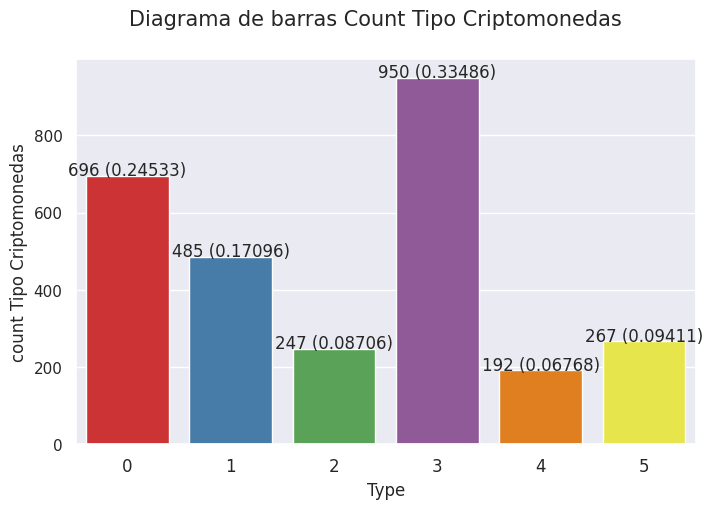

In [121]:
plot_bar(
    data,
    paleta=None,
    ejeX='Type',
    ejey='count Tipo Criptomonedas',
    title='Count Tipo Criptomonedas',
    p=True)

# **Split**
---

Based on previous experience with other processes using this dataset, the following features are selected, as they provide relevant information to the models

In [122]:
X = data[['p1_d', 'p2_d', 'min_d', '#packets', 'Avg_bpp', 'p2_ip', 'p3_ip',
       'p2_ib']]
y = data.iloc[:,-1].astype(int)

A 20% split will be used for testing, with stratified sampling and random shuffling

In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.8,
    random_state=random_seed,
    shuffle=True,
    stratify=y
)

The data is standardized

In [124]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Model**
---

A function is defined to obtain the conventional models for the ensemble growth and pruning process

In [125]:
def get_models():
  models = []
  models.append(('lr', LogisticRegression(random_state=random_seed)))
  models.append(('knn', KNeighborsClassifier()))
  models.append(('Tree', DecisionTreeClassifier(random_state=random_seed)))
  models.append(('nb', GaussianNB()))
  models.append(('svm', SVC(probability=True, random_state=random_seed)))
  return models

Another function is defined that validates the performance of a model or ensemble of models using stratified cross-validation

In [126]:
def evaluate_model(model, X, y):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_seed)
  scores = cross_val_score(model, X,y, scoring = 'f1_micro', cv=cv, n_jobs=-1)
  return scores

In [127]:
models = get_models()

results, names = [], []

for name, model in models:
  scores = evaluate_model(model, X_train, y_train)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.928 (0.034)
>knn 0.954 (0.028)
>Tree 0.942 (0.026)
>nb 0.749 (0.055)
>svm 0.904 (0.033)


- KNN (0.95) and Tree (0.94) are the models with the best average performance. Not only do they have the highest mean scores, but they also demonstrate high stability (low deviation).

- SVM (0.90) and LR (0.93) show good performance as well, though slightly lower.

- NB (0.75) has a considerably lower average performance and is also the most inconsistent model, showing greater variability across folds.

A reference set that includes all the models must be defined. This will serve as a basis for comparing the different growth and pruning methods.

A voting ensemble with soft voting will be used. This means that each model will predict probabilities, and the ensemble model will sum them to produce a final output prediction for each input sample.

In [128]:
ensemble = VotingClassifier(estimators=models, voting='soft')

In [129]:
scores = evaluate_model(ensemble, X_train, y_train)
print('Mean f1: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean f1: 0.961 (0.028)


The ensemble slightly improves the average compared to KNN and Tree, while maintaining a low (consistent) standard deviation

In [130]:
results = results+[scores]
names = names+['VotingClassifier']

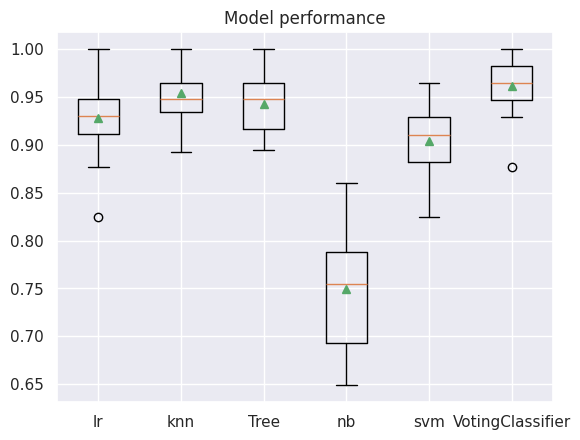

In [131]:
fig, ax = plt.subplots()
ax.boxplot(results, labels=names, showmeans=True)
ax.set_title("Model performance")
plt.show()

Although the KNN and Tree models have the best performance, it is evident that the ensemble voting models show high performance with low variability compared to the other individual models. Therefore, it can be said that the ensemble models improve their performance. However, there is also a possibility of overfitting.

# **Ensemble Pruning**

---



A greedy algorithm will be used,this involves removing one member from the ensemble at a time, evaluating performance, and repeating the process for each member. The member whose removal results in the greatest improvement in performance is permanently excluded from the ensemble. This process is repeated until no further improvements can be achieved

Evaluate the models for pruning

In [132]:
def evaluate_ensemble(modelsPruning, X_train, y_train):
  if len(modelsPruning) == 0:
    return 0
  ensemble = VotingClassifier(estimators=modelsPruning, voting='soft')
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_seed)
  score = cross_val_score(ensemble, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
  return mean(score)

Based on the evaluation, determine which model should be discarded from the ensemble model.

In [133]:
def prune_round(models, X, y):
  baseline = evaluate_ensemble(models, X, y)
  best_score, remove = baseline, None
  for model in models:
    modelsCopy = models.copy()
    modelsCopy.remove(model)
    scoreP = evaluate_ensemble(modelsCopy, X, y)
    if scoreP > best_score:
      best_score, remove = scoreP, model
  return best_score, remove

Remove the models whose presence in the ensemble does not contribute to an improvement.


In [134]:
def prune_ensemble(models, X, y):
  best_score = 0
  noBreak = True
  while noBreak:
    score, removeModel= prune_round(models, X, y)
    if removeModel != None:
      models.remove(removeModel)
      if score > best_score:
        best_score = score
      print('>%.3f (removed: %s)' % (score, removeModel))
    else:
      noBreak = False

  return best_score, models


In [135]:
models = get_models()
score, model_list = prune_ensemble(models, X_train, y_train)

>0.942 (removed: ('nb', GaussianNB()))
>0.943 (removed: ('svm', SVC(probability=True, random_state=12354)))
>0.944 (removed: ('lr', LogisticRegression(random_state=12354)))


In [136]:
names = ','.join([m for m ,_ in model_list])
names

'knn,Tree'

It can be observed that three pruning rounds were carried out, eliminating the Naive Bayes, Support Vector Machine, and Logistic Regression algorithms, leaving only the Decision Tree and KNN algorithms, which achieved an average F1 score of approximately 94%.

In [137]:
print('Models: %s' % names)
print('Final Mean F1 score: %.3f' % score)

Models: knn,Tree
Final Mean F1 score: 0.944


# **Info**
---
**@By:** Kaiziferr

**@Git:** https://github.com/Kaiziferr